In [ ]:
!pip3 install catboost

In [ ]:
import pandas as pd
import numpy as np
# import dask.dataframe as dd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
import gc
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm.notebook import tqdm
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn import model_selection
import lightgbm as lgbm
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
WORK_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/DFC'
DATA_PATH = WORK_DIR + '/Data/data_fusion_train.parquet'

In [ ]:
import pandas as pd
import numpy as np

###Первый взгляд на данные

In [ ]:
%%time
use_threads=False
df = pd.read_parquet(DATA_PATH)

CPU times: user 20.7 s, sys: 4.03 s, total: 24.7 s
Wall time: 19.4 s


In [ ]:
df.shape

(26094077, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int64  
 1   receipt_dayofweek  int32  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float64
 5   item_price         int64  
 6   item_nds_rate      int32  
 7   category_id        int64  
 8   brands             object 
dtypes: float64(1), int32(2), int64(3), object(3)
memory usage: 1.7+ GB


In [ ]:
# поля Dtype == object, занимают лишнее место

In [ ]:
df.columns

Index(['receipt_id', 'receipt_dayofweek', 'receipt_time', 'item_name',
       'item_quantity', 'item_price', 'item_nds_rate', 'category_id',
       'brands'],
      dtype='object')

In [ ]:
df.head()

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
0,7,5,09:50,Флуконазол капс 150мг №1 Вертекс,1.0,7,-1,-1,вертекс
1,11,6,20:34,"Молоко 3,2%,шт",2.0,8,2,78,None
2,39,4,11:28,"Борщ Станичный с тушенкой, 103 ккал (завод, з/у)",1.0,6,1,-1,None
3,39,4,11:28,"Компот из изюма, 114 ккал",1.0,4,1,71,None
4,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.0,4,1,71,None


In [ ]:
df.describe()

,receipt_id,receipt_dayofweek,item_quantity,item_price,item_nds_rate,category_id
count,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07
mean,5.008370e+06,3.079493e+00,1.413864e+09,8.723268e+00,2.315496e+00,2.537151e+01
std,2.891319e+06,1.989730e+00,5.106975e+12,3.769641e+00,2.240315e+00,5.376522e+01
min,2.000000e+00,0.000000e+00,1.000000e-03,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,2.505699e+06,1.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,-1.000000e+00
50%,5.008298e+06,3.000000e+00,1.000000e+00,9.000000e+00,2.000000e+00,-1.000000e+00
75%,7.511943e+06,5.000000e+00,1.000000e+00,1.100000e+01,4.000000e+00,-1.000000e+00
max,1.001617e+07,6.000000e+00,1.844674e+16,4.200000e+01,6.000000e+00,2.040000e+02


In [ ]:
map_cols_to_type = {
    'category_id': np.int16,
    'item_nds_rate' : np.int16,
    'item_price' : np.int16,
    'item_quantity' : np.float32,
    'receipt_dayofweek' : np.int16,
    'receipt_id' : np.int32
}

In [ ]:
for key in map_cols_to_type:
  df[key] = df[key].astype(map_cols_to_type[key])

In [ ]:
df.info() # практически 500 мб освободили

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int32  
 1   receipt_dayofweek  int16  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float32
 5   item_price         int16  
 6   item_nds_rate      int16  
 7   category_id        int16  
 8   brands             object 
dtypes: float32(1), int16(4), int32(1), object(3)
memory usage: 1.2+ GB


#Data Understanding

In [ ]:
df.shape

(26094077, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int64  
 1   receipt_dayofweek  int32  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float64
 5   item_price         int64  
 6   item_nds_rate      int32  
 7   category_id        int64  
 8   brands             object 
dtypes: float64(1), int32(2), int64(3), object(3)
memory usage: 1.7+ GB


In [ ]:
%load_ext google.colab.data_table
df.head(10)

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
0,7,5,09:50,Флуконазол капс 150мг №1 Вертекс,1.0,7,-1,-1,вертекс
1,11,6,20:34,"Молоко 3,2%,шт",2.0,8,2,78,None
2,39,4,11:28,"Борщ Станичный с тушенкой, 103 ккал (завод, з/у)",1.0,6,1,-1,None
3,39,4,11:28,"Компот из изюма, 114 ккал",1.0,4,1,71,None
4,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.0,4,1,71,None
6,39,4,11:28,"Филе Горизонт (филе птицы), 218 ккал",1.0,7,1,-1,горизонт
10,49,3,14:27,3 Бумага Упак 1/Прочи/В асс,1.0,8,1,-1,None
11,49,3,14:27,4 Бумага Упак 1/Прочи/В асс,1.0,8,1,-1,None
12,49,3,14:27,Брюки спорт мал SAMO M-1016,1.0,13,6,-1,None
13,49,3,14:27,Бюстгальтер БН137,1.0,13,-1,-1,None


In [ ]:
df.describe()

,receipt_id,receipt_dayofweek,item_quantity,item_price,item_nds_rate,category_id
count,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07
mean,5.008370e+06,3.079493e+00,1.413864e+09,8.723268e+00,2.315496e+00,2.537151e+01
std,2.891319e+06,1.989730e+00,5.106975e+12,3.769641e+00,2.240315e+00,5.376522e+01
min,2.000000e+00,0.000000e+00,1.000000e-03,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,2.505699e+06,1.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,-1.000000e+00
50%,5.008298e+06,3.000000e+00,1.000000e+00,9.000000e+00,2.000000e+00,-1.000000e+00
75%,7.511943e+06,5.000000e+00,1.000000e+00,1.100000e+01,4.000000e+00,-1.000000e+00
max,1.001617e+07,6.000000e+00,1.844674e+16,4.200000e+01,6.000000e+00,2.040000e+02


In [ ]:
count_category = df['category_id'].value_counts().reset_index()

In [ ]:
count_category.columns = ['category', 'count']

In [ ]:
count_category.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
category,-1,203,84,80,78,71,83,77,69,204,79,38,74,70,81,0,40,73,130,76,139,75,85,145,117,82,92,61,68,51,72,67,7,30,66,49,2,118,45,43,...,103,140,41,9,138,96,107,167,163,109,128,6,27,115,53,90,26,11,164,60,24,13,105,56,101,111,39,35,102,54,55,108,58,100,1,106,97,46,143,121
count,19610851,1307260,902507,670833,503199,422085,322656,193369,186312,136271,126837,126410,101648,94482,93440,92280,88427,88121,80566,80476,71907,69004,67961,64365,55324,45508,41629,39821,30077,26690,24865,21723,17756,17168,16823,16274,15502,15353,14597,14362,...,3695,3252,2871,2569,2565,2443,2377,2064,2042,1988,1914,1814,1787,1710,1646,1642,1470,1435,1388,1158,1149,801,741,690,626,612,507,480,459,456,444,406,356,312,226,183,109,67,25,1


In [ ]:
df = df[df['category_id'] != -1]

In [ ]:
df.shape

(6483226, 9)

In [ ]:
df.columns

Index(['receipt_id', 'receipt_dayofweek', 'receipt_time', 'item_name',
       'item_quantity', 'item_price', 'item_nds_rate', 'category_id',
       'brands'],
      dtype='object')

#Duplicate view

In [ ]:
Duplicated_set = set([203,  78,  75, 204,  83,  79,  77,  69,  80,  40,  84,  53,  70,
        81,  73, 130,  71,  38, 145,  68,  74,  66,  92,  85,  45,  61,
       103, 120,  76, 118, 117,   0,  37, 139, 177,  51,  82,  31,  19,
         2,  72, 107,  12, 101,  50,  67,  49,   3,   7,  36,  30,  57,
        52,  20, 133,  41,  43,  27,  42, 150, 163, 143,  62,   4, 138,
         6,  29,  24, 167, 109,  26,   9, 102, 128,  13,  35, 115, 140,
        90,  56, 114, 100,  96, 164, 108,  60, 105,  11,  39, 111,  55,
        54,  97,   1,  46, 106,  58, 121])

In [ ]:
df[df['item_name'].duplicated()][df['category_id'] == 203]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
150,356,2,13:07,Пакет,1.0,3,6,203,None
185,558,1,13:55,Пакет,1.0,3,6,203,None
195,562,5,15:29,Пакет,1.0,0,1,203,None
226,674,6,13:19,Пакет,1.0,2,6,203,None
491,1005,5,22:20,Пакет,1.0,3,1,203,None
...,...,...,...,...,...,...,...,...,...
45729122,10015886,4,13:16,Пакет,1.0,2,6,203,None
45729143,10015906,5,10:48,Пакет,1.0,2,6,203,None
45729164,10015942,5,15:51,Пакет,1.0,2,1,203,None
45729264,10016106,6,12:18,Пакет,1.0,3,1,203,None


In [ ]:
df[df['item_name'].duplicated()][df['category_id'] == 84]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
3034,6049,0,11:52,"Хлеб столичный 37,7",2.00,2,1,84,None
3281,6641,4,18:47,Шоколад Твикс Экстра 82г,1.00,8,1,84,None
3733,7550,1,12:10,БУЛОЧКА АШАН 30Г,70.00,2,1,84,ашан
3997,8182,3,15:18,ЧЕБУРЕК С МЯСОМ ШТ,1.00,8,2,84,None
4070,8253,5,17:41,БУЛОЧКА АШАН 30Г,6.00,2,1,84,ашан
...,...,...,...,...,...,...,...,...,...
45729091,10015820,5,13:11,Хлеб на закваске пшеничный 490 г,0.41,9,2,84,None
45729103,10015826,0,09:09,ЖевРез Орбит Лайм 14г,1.00,6,1,84,орбит
45729135,10015906,5,10:48,БАТОНЧИК КИНДЕР БУЭНО ФЕРРЕРО 42-43Г,1.00,8,6,84,None
45729153,10015923,4,09:23,"Печенье в шок. глазури ""Чоко Пай"" 168г",1.00,8,1,84,чоко пай


In [ ]:
df[df['item_name'].duplicated()][df['category_id'] == 80]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
2247,4440,5,09:05,ЯБЛОКИ АЙДАРЕД,1.091,10,1,80,None
3058,6115,6,19:51,Апельсины импорт 1кг,1.190,10,1,80,None
4198,8449,3,13:23,МАНДАРИНЫ КНОПКА 33,1.103,9,2,80,None
4203,8466,3,16:08,БАНАНЫ КНОПКА 18,1.434,8,1,80,None
4229,8536,2,18:05,Морковь мытая КНР,0.996,8,2,80,None
...,...,...,...,...,...,...,...,...,...
45728821,10015122,4,13:03,ГРИБЫ ШАМПИНЬОНЫ,1.000,10,2,80,None
45728823,10015122,4,13:03,ЛУК,0.240,7,2,80,None
45728851,10015174,4,16:31,ТОМАТЫ НА ВЕТКЕ КНОПКА 179,0.771,11,2,80,None
45729074,10015820,5,13:11,ОГУРЕЦ ПУПЫРЧАТЫЙ СР,0.339,8,2,80,None


In [ ]:
df[df['item_name'].duplicated()][df['category_id'] == 78]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
702,1399,4,17:17,Пакет,1.0,9,2,78,None
2829,5606,1,16:30,"Молоко Мудрая хозяйка 2,5% пленка 0,8 л БЗМЖ",2.0,6,2,78,None
3318,6694,3,09:51,"Молоко 3,2%,шт",1.0,8,2,78,None
4104,8277,2,19:16,СМЕТАНА 20% 300Г,2.0,8,2,78,None
4245,8563,3,10:55,"Сметана 10г, 16 ккал",1.0,2,1,78,None
...,...,...,...,...,...,...,...,...,...
45729120,10015886,4,13:16,"Молоко Фермерское подворье 3,5% 1л ЭДЖ",1.0,9,6,78,None
45729144,10015906,5,10:48,ЯЙЦО СТОЛОВОЕ 1КАТ МЫТОЕ ПФ ПИОНЕРСКОЕ 1ШТ,5.0,4,6,78,None
45729203,10016005,3,22:58,Масло сливочное,1.0,4,6,78,None
45729205,10016005,3,22:58,"Молоко цельное 0,250, 149 ккал",2.0,5,1,78,None


In [ ]:
df[df['item_name'].duplicated()][df['category_id'] == 71]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
5745,11937,4,13:21,Картофельное пюре,1.000,6,6,71,None
6110,12933,2,21:32,Сырники жареные 140 г Уже Гото,1.000,11,2,71,None
7683,16490,2,12:23,Картофельное пюре,1.000,7,6,71,None
7791,16774,2,18:26,Филе из грудки куриной по-венециански 95,1.000,8,1,71,None
8964,19206,4,12:36,Салат Сельдь под шубой,0.344,13,1,71,None
...,...,...,...,...,...,...,...,...,...
45728937,10015483,2,12:48,"Салат из б/ капусты с перцем, луком зел 100",1.000,5,1,71,None
45728976,10015503,1,17:45,Картофельное пюре(160гр),1.000,7,-1,71,None
45729184,10015977,4,13:41,"Салат ""Грин Энерджи"",шт",1.000,10,1,71,None
45729202,10016005,3,22:58,Макаронные изделия отварные (масло сливочное) ...,1.000,4,1,71,None


In [ ]:
df[df['item_name'].duplicated()][df['category_id'] == 83]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
1232,2386,1,20:56,КОКА-КОЛА СТД. СКОМБО,1.0,8,1,83,кока-кола
1560,2997,1,14:08,КОКА-КОЛА СТД. СКОМБО,1.0,8,1,83,кока-кола
2073,4116,6,21:34,"0,4 Пепси-кола мал",1.0,9,1,83,пепси-кола
2497,5011,2,16:21,КОКА-КОЛА СТД. СКОМБО,1.0,8,1,83,кока-кола
3029,6049,0,11:52,Компот из св. м.ягоды (клубника или вишня или ...,1.0,5,1,83,None
...,...,...,...,...,...,...,...,...,...
45728833,10015125,5,10:42,"ВОДА МАЛКИНСКАЯ №1 ГАЗ ПЛ/Б 1,5Л",1.0,8,6,83,None
45728890,10015301,2,13:22,Напиток из смеси сухофруктов,1.0,4,1,83,None
45729152,10015923,4,09:23,"Нап. сокосод. ябл.вишн. Родной 0,2л",1.0,4,2,83,None
45729162,10015942,5,15:51,"НАПИТОК БАРБАРИС ФРУКТОМАНИЯ ПЭТ 1,5 Л",1.0,7,6,83,None


In [ ]:
df[df['item_name'].duplicated()][df['category_id'] == 77]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
1713,3259,5,21:49,САХАР 900 Г ПЕСОК,3.0,6,2,77,None
1776,3391,4,15:51,100Г ГОРЧИЦА ЯДРЕН ТУБА ГЛАВПР,1.0,6,1,77,None
3200,6570,0,12:34,Горчица столовая 10,1.0,1,1,77,None
3483,6962,4,16:10,САХАР 900 Г ПЕСОК,3.0,7,2,77,None
3522,7050,0,15:35,Хрен столовый Трофимыч 130г Юдинцев,2.0,7,1,77,None
...,...,...,...,...,...,...,...,...,...
45728438,10014348,5,10:45,"Ванильн сахар""д-рОетк""8г",1.0,4,1,77,None
45728582,10014753,5,14:06,Соус клюквенный,1.0,6,1,77,None
45728608,10014865,5,08:45,Хрен столовый Трофимыч 130г Юдинцев,1.0,7,1,77,None
45728659,10014978,4,18:23,370ГР ГОРЧИЦА ОСТ. ДИЖОНС.БОРНЬЕ,1.0,12,1,77,None


In [ ]:
df[df['item_name'].duplicated()][df['category_id'] == 69]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
2078,4116,6,21:34,Станд Картофель фри,1.0,9,1,69,None
2348,4638,1,20:31,Станд Картофель фри,1.0,9,1,69,None
2496,5011,2,16:21,КАРТОФ.ФРИ СТ. СКОМБО,1.0,8,1,69,None
3548,7093,5,23:45,КАРТОФ.ФРИ СТ. СКОМБО,1.0,8,1,69,None
4534,9154,1,01:27,Станд Картофель фри,1.0,9,6,69,None
...,...,...,...,...,...,...,...,...,...
45728460,10014471,6,19:22,БоксМастер Темный СЛ,1.0,12,2,69,мастер
45728579,10014753,5,14:06,КАРТОФ.ФРИ СТ. СКОМБО,1.0,8,1,69,None
45728580,10014753,5,14:06,Острый Шефбургер Новый СБ,2.0,11,6,69,None
45729020,10015592,3,17:27,Купон 3844: Станд Картофель фри,1.0,8,1,69,None


In [ ]:
df[df['item_name'].duplicated()][df['category_id'] == 204]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
1168,2274,2,17:59,Доставка,1.0,0,1,204,None
1623,3128,4,08:18,Товар 1,1.0,6,6,204,None
1868,3567,3,16:20,Доставка,1.0,0,1,204,None
2514,5064,1,09:44,Доставка,1.0,0,1,204,None
3872,7848,0,12:35,Доставка,1.0,0,1,204,None
...,...,...,...,...,...,...,...,...,...
45726702,10010380,5,11:47,"ООО ""Водоканал-Сервис"" (КРЦ)",1.0,13,6,204,None
45726813,10010588,6,11:46,Доставка,1.0,0,1,204,None
45727108,10011336,3,16:52,Товар 1,1.0,9,6,204,None
45728157,10013915,3,19:10,Доставка,1.0,0,1,204,None


In [ ]:
df[df['item_name'].duplicated()][df['category_id'] == 79]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
1391,2734,4,11:39,ФИЛЕ ЦБ БЕЗ КОЖИ ПОДЛ (ОХЛ),2.999,12,2,79,None
5053,10218,6,12:40,Пакет,3.540,10,2,79,None
8498,18369,1,09:42,БЕДРО С/КОЖ Б/КРЕС.Ч. ТМ ПЕТЕЛ,2.065,13,2,79,None
11170,24280,4,15:11,ФИЛЕ ЦБ БЕЗ КОЖИ ПОДЛ (ОХЛ),1.045,12,2,79,None
11910,25506,2,19:52,Пакет,2.767,12,2,79,None
...,...,...,...,...,...,...,...,...,...
45727399,10012217,0,14:33,МЯСО СВИНЫХ ГОЛОВ В ФОРМЕ В/УП ТМ МЯСНОЙ РЯД 1КГ,0.425,14,6,79,None
45727411,10012238,6,09:19,ГОЛЕНЬ ЦЫПЛ-БРОЙ ОХЛ,0.660,11,2,79,None
45728380,10014274,2,19:52,Пакет,2.170,10,2,79,None
45728570,10014684,3,20:38,Набор д/тушения охл подложка Амурский Бройлер,0.928,10,2,79,None


# Расшифровка Признаков



*   receipt_id —  id чека;
*   receipt_dayofweek — день недели;
*   receipt_time — время создания чека;
*   item_name — наименование товара;
*   item_quantity — количество товара;
*   item_price — цена товара;
*   item_nds_rate — ставка НДС;
*   category_id — категория товара. 

















In [ ]:
df['item_nds_rate'].describe()

count    6.483226e+06
mean     1.904666e+00
std      1.857853e+00
min     -1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.000000e+00
Name: item_nds_rate, dtype: float64

In [ ]:
df[df['item_name'].duplicated()]['category_id'].unique()

array([203,  78,  75, 204,  83,  79,  77,  69,  80,  40,  84,  53,  70,
        81,  73, 130,  71,  38, 145,  68,  74,  66,  92,  85,  45,  61,
       103, 120,  76, 118, 117,   0,  37, 139, 177,  51,  82,  31,  19,
         2,  72, 107,  12, 101,  50,  67,  49,   3,   7,  36,  30,  57,
        52,  20, 133,  41,  43,  27,  42, 150, 163, 143,  62,   4, 138,
         6,  29,  24, 167, 109,  26,   9, 102, 128,  13,  35, 115, 140,
        90,  56, 114, 100,  96, 164, 108,  60, 105,  11,  39, 111,  55,
        54,  97,   1,  46, 106,  58, 121])

#Dataset Transforming

In [ ]:
df = df[df['category_id'] != -1]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6483226 entries, 1 to 45729281
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int64  
 1   receipt_dayofweek  int32  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float64
 5   item_price         int64  
 6   item_nds_rate      int32  
 7   category_id        int64  
 8   brands             object 
dtypes: float64(1), int32(2), int64(3), object(3)
memory usage: 445.2+ MB


In [ ]:
map_column_to_type = {
    'category_id': np.int16,
    'item_nds_rate': np.int16,
    'item_price': np.int16,
    'item_quantity': np.float32,
    'receipt_dayofweek': np.int16,
    'receipt_id': np.int32,
#     'receipt_time': pd.StringDtype(),
#     'item_name': pd.StringDtype(),
#     'brands': pd.StringDtype()
}
for key in map_column_to_type:
    df[key] = df[key].astype(map_column_to_type[key])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6483226 entries, 1 to 45729281
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int32  
 1   receipt_dayofweek  int16  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float32
 5   item_price         int16  
 6   item_nds_rate      int16  
 7   category_id        int16  
 8   brands             object 
dtypes: float32(1), int16(4), int32(1), object(3)
memory usage: 296.8+ MB


In [ ]:
gr_item_name = df.groupby('item_name')
df['mean_item_quantity'] = gr_item_name['item_quantity'].transform("mean")
df['sum_item_quantity'] = gr_item_name['item_quantity'].transform("sum")
df['std_item_quantity'] = gr_item_name['item_quantity'].transform("std")
df['min_item_quantity'] = gr_item_name['item_quantity'].transform("min")
df['max_item_quantity'] = gr_item_name['item_quantity'].transform("max")

df['mean_item_price'] = gr_item_name['item_price'].transform("mean")
df['sum_item_price'] = gr_item_name['item_price'].transform("sum")
df['std_item_price'] = gr_item_name['item_price'].transform("std")
df['min_item_price'] = gr_item_name['item_price'].transform("min")
df['max_item_price'] = gr_item_name['item_price'].transform("max")

df['mean_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("mean")
df['sum_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("sum")
df['std_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("std")
df['min_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("min")
df['max_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("max")


df['hours'] = df['receipt_time'].apply(lambda x: int(x.split(":")[0]))

df['mean_hours'] = gr_item_name['hours'].transform("mean")
df['sum_hours'] = gr_item_name['hours'].transform("sum")
df['std_hours'] = gr_item_name['hours'].transform("std")
df['min_hours'] = gr_item_name['hours'].transform("min")
df['max_hours'] = gr_item_name['hours'].transform("max")


df['median_dayofweek'] = gr_item_name['receipt_dayofweek'].transform('median')
df['median_dayofweek'] = df['median_dayofweek'].astype(np.int8)

In [ ]:
df_uni = df.drop_duplicates('item_name')

In [ ]:
df_uni.shape

(48225, 31)

In [ ]:
!pip3 install catboost

     |████████████████████████████████| 65.7MB 44kB/s 


In [ ]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
import gc
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm.notebook import tqdm
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn import model_selection
import lightgbm as lgbm
import warnings

warnings.filterwarnings('ignore')

#WordCloud

In [ ]:
!pip3 install wordcloud

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
def get_text_all_category(data, category_id):
    text = " "
    category = data[data.category_id == category_id]
    for idx, row in tqdm(category.iterrows(), total=category.shape[0]):
        text += row['item_name'] + " "
    return text

def plot_category(data, category_id, figsize=(7, 5)):
    plt.figure(figsize=figsize)
    category = get_text_all_category(data, category_id)
    wordcloud = WordCloud(max_font_size=40).generate(category)
    print(f'Category: {category_id}')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


Category: 203


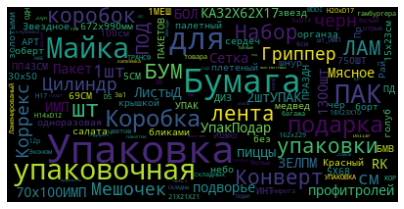

In [ ]:
plot_category(df_uni, 203)


Category: 84


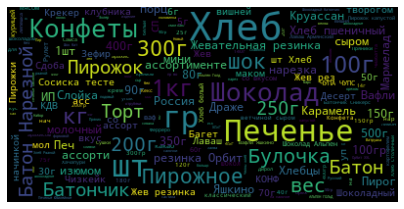

In [ ]:
plot_category(df_uni, 84)


Category: 80


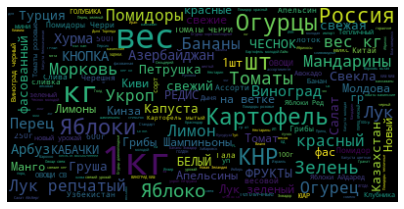

In [ ]:
plot_category(df_uni, 80)


Category: 78


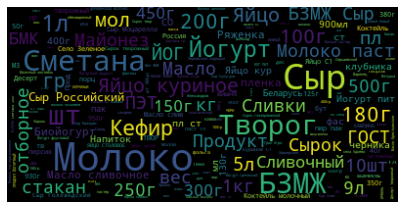

In [ ]:
plot_category(df_uni, 78)


Category: 71


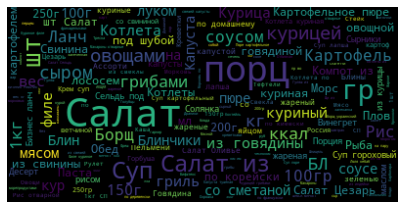

In [ ]:
plot_category(df_uni, 71)

# Моделирование

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
assert gpu.memoryFree > 12000

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=a2d184b45950a09f95956697511ac67e80099304e57504318a851e9ab7af4b9f
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
train, valid = model_selection.train_test_split(df_uni,
                                                test_size=0.10, 
                                                stratify=df_uni['category_id'], 
                                                shuffle=True, random_state=10)

In [ ]:
train.head()

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,mean_item_quantity,sum_item_quantity,std_item_quantity,min_item_quantity,max_item_quantity,mean_item_price,sum_item_price,std_item_price,min_item_price,max_item_price,mean_item_nds_rate,sum_item_nds_rate,std_item_nds_rate,min_item_nds_rate,max_item_nds_rate,hours,mean_hours,sum_hours,std_hours,min_hours,max_hours,median_dayofweek
216804,474787,3,10:37,EGOISTE ESPRESSO МОЛ,1.0,13,1,84,egoiste,1.285714,27.0,0.643650,1.0,3.0,13.142857,276.0,0.358569,13,14,1.0,21.0,0.0,1,1,10,14.809524,311,3.400280,8,21,2
12663919,7717680,5,13:56,ПОДСВЕТКА НЕОНОВАЯ 1 МЕТР БЕЛАЯ 12-24 В,1.0,14,1,128,None,1.333333,4.0,0.577350,1.0,2.0,14.000000,42.0,0.000000,14,14,1.0,3.0,0.0,1,1,13,15.666667,47,4.618802,13,21,5
852935,1877634,4,20:13,КАПУСТА КВАШ КИСЛО-СЛАДКАЯ 1КГ,1.0,11,1,75,None,1.223881,82.0,0.755202,1.0,6.0,10.985075,736.0,0.122169,10,11,1.0,67.0,0.0,1,1,20,14.611940,979,4.441387,4,22,4
3182690,6969354,1,08:25,Энергетический напиток С.О.В.А. Апельсин,1.0,10,1,83,None,1.000000,3.0,0.000000,1.0,1.0,10.000000,30.0,0.000000,10,10,1.0,3.0,0.0,1,1,8,14.666667,44,6.110101,8,20,1
1554564,3411092,5,12:08,"Растворитель Р-4 0,5л ЯСХИМ",1.0,10,6,108,ясхим,1.076923,14.0,0.277350,1.0,2.0,9.615385,125.0,0.506370,9,10,6.0,78.0,0.0,6,6,12,13.384615,174,2.180920,11,18,4


In [ ]:
train.columns

Index(['receipt_id', 'receipt_dayofweek', 'receipt_time', 'item_name',
       'item_quantity', 'item_price', 'item_nds_rate', 'category_id', 'brands',
       'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity',
       'min_item_quantity', 'max_item_quantity', 'mean_item_price',
       'sum_item_price', 'std_item_price', 'min_item_price', 'max_item_price',
       'mean_item_nds_rate', 'sum_item_nds_rate', 'std_item_nds_rate',
       'min_item_nds_rate', 'max_item_nds_rate', 'hours', 'mean_hours',
       'sum_hours', 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek'],
      dtype='object')

In [ ]:
feature_names = ['receipt_id', 'receipt_dayofweek', 'receipt_time', 
                 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 
                 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 
                 'min_item_quantity', 'max_item_quantity', 'mean_item_price',
                 'sum_item_price', 'std_item_price', 'min_item_price',
                 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 
                 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 
                 'hours', 'mean_hours', 'sum_hours', 
                 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek']

cat_features = ['receipt_time', 'receipt_id']
text_features = ['item_name']
target = 'category_id'

In [ ]:

model = CatBoostClassifier(
    cat_features=cat_features,
    text_features=text_features,
    verbose=50,
    loss_function='MultiClass',
    eval_metric='TotalF1',
     task_type="GPU",
    iterations=1000,
    learning_rate=0.2,            
)

In [ ]:
# model.fit(
#     train[feature_names], train[target],
#     eval_set=(valid[feature_names], valid[target]),
#     plot=True
# )

In [ ]:
model = CatBoostClassifier(
    cat_features=cat_features,
    text_features=text_features,
    verbose=50,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type="GPU",
    iterations=1000,
    learning_rate=0.2,      
#     reg_lambda=0.0001,
    
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "150000",
            "occurrence_lower_bound" : "1",
            "gram_order" : "2"
        },{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
        },{
            "dictionary_id" : "Fourgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "4"
        },{
            "dictionary_id" : "Fivegram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "5"
        },{
            "dictionary_id" : "Sixgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "6"
        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)

In [ ]:
def create_features(data):
    data['first'] = data['item_name'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    data['last'] = data['item_name'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else 'none')
    data['is_preservativ'] = data.item_name.apply(lambda x: int('презерватив' in x.lower()))
    data['is_auto'] = data.item_name.apply(lambda x: int('авто' in x.lower() or \
                                                            'щетк' in x.lower() or \
                                                             'сантиметр' in x.lower()))

    data['is_paper'] = data.item_name.apply(lambda x: int('бумага' in x.lower()))
    data['is_otkritka'] = data.item_name.apply(lambda x: int('открытка' in x.lower()))
    data['is_born'] = data.item_name.apply(lambda x: int('рождения' in x.lower()))
    data['is_a4'] = data.item_name.apply(lambda x: int('а4' in x.lower()))
    data['is_ubiley'] = data.item_name.apply(lambda x: int('юбиле' in x.lower()))

    #24
    data['is_list'] = data.item_name.apply(lambda x: int('лист' in x.lower()))
    data['is_kanc'] = data.item_name.apply(lambda x: int('канцелярский' in x.lower()))
    data['is_dnevnik'] = data.item_name.apply(lambda x: int('дневник' in x.lower()))
    
    data['second_last_word'] = data.item_name.apply(lambda x: x.split()[-2] if len(x.split()) > 1 else 'none')
    data['second_first_word'] = data.item_name.apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'none')

    data['first_word_len'] = data['first'].apply(len)
    data['last_word_len'] = data['last'].apply(len)

    data['item_name_len'] = data.item_name.apply(lambda x: len(x.split()))

    data['last_first_word'] = data['last'] + data['first']
    return data

In [ ]:

train = create_features(train)

valid = create_features(valid)

In [ ]:

train.isnull().sum()

receipt_id                0
receipt_dayofweek         0
receipt_time              0
item_name                 0
item_quantity             0
item_price                0
item_nds_rate             0
category_id               0
brands                36704
mean_item_quantity        0
sum_item_quantity         0
std_item_quantity      7315
min_item_quantity         0
max_item_quantity         0
mean_item_price           0
sum_item_price            0
std_item_price         7315
min_item_price            0
max_item_price            0
mean_item_nds_rate        0
sum_item_nds_rate         0
std_item_nds_rate      7315
min_item_nds_rate         0
max_item_nds_rate         0
hours                     0
mean_hours                0
sum_hours                 0
std_hours              7315
min_hours                 0
max_hours                 0
median_dayofweek          0
first                     0
last                      0
is_preservativ            0
is_auto                   0
is_paper            

In [ ]:
def fill_median(df):
    df['std_item_quantity'] = df['std_item_quantity'].fillna(np.nanmedian(df['std_item_quantity']))
    df['std_item_price'] = df['std_item_price'].fillna(np.nanmedian(df['std_item_price']))
    df['std_item_nds_rate'] = df['std_item_nds_rate'].fillna(np.nanmedian(df['std_item_nds_rate']))
    df['std_hours'] = df['std_hours'].fillna(np.nanmedian(df['std_hours']))
    return df

In [ ]:
train = fill_median(train)
valid = fill_median(valid)

In [ ]:
train.isnull().sum()

receipt_id                0
receipt_dayofweek         0
receipt_time              0
item_name                 0
item_quantity             0
item_price                0
item_nds_rate             0
category_id               0
brands                36704
mean_item_quantity        0
sum_item_quantity         0
std_item_quantity         0
min_item_quantity         0
max_item_quantity         0
mean_item_price           0
sum_item_price            0
std_item_price            0
min_item_price            0
max_item_price            0
mean_item_nds_rate        0
sum_item_nds_rate         0
std_item_nds_rate         0
min_item_nds_rate         0
max_item_nds_rate         0
hours                     0
mean_hours                0
sum_hours                 0
std_hours                 0
min_hours                 0
max_hours                 0
median_dayofweek          0
first                     0
last                      0
is_preservativ            0
is_auto                   0
is_paper            

In [ ]:

# model.fit(
#     train[feature_names], train[target],
#     eval_set=(valid[feature_names], valid[target]),
#     plot=True
# )

In [ ]:
import pickle
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(valid.category_id.values, model.predict(valid[feature_names])))

In [ ]:
importance = model.get_feature_importance(prettified=True)
importance

,Feature Id,Importances
0,item_name,91.354950
1,receipt_id,1.976331
2,receipt_time,0.975415
3,mean_item_price,0.844131
4,mean_item_nds_rate,0.588999
5,min_item_price,0.498766
6,mean_hours,0.476246
7,mean_item_quantity,0.379733
8,max_item_price,0.374805
9,sum_item_price,0.342295


#Preprocessing

In [ ]:
!git clone https://github.com/natasha/razdel.git

Cloning into 'razdel'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 505 (delta 88), reused 101 (delta 51), pack-reused 343
Receiving objects: 100% (505/505), 42.67 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (297/297), done.


In [ ]:
!pip install razdel

In [ ]:

from razdel import tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import string
RU_STOP_WORDS = set(stopwords.words('russian'))

# def prepare(token):
#     return re.sub("[^0-9A-Za-zА-Яа-я ]", "", token)
    

def pre_process(text):
    return " ".join([token.lower() for token in [_.text for _ in tokenize(text)]
                     if (token not in RU_STOP_WORDS) or (token not in string.punctuation)])

In [ ]:

train['item_name_tmp'] = train['item_name'].values
valid['item_name_tmp'] = valid['item_name'].values

train['item_name'] = train.item_name.apply(pre_process)
valid['item_name'] = valid.item_name.apply(pre_process)

In [ ]:
train = create_features(train)
valid = create_features(valid)

In [ ]:
train = fill_median(train)
valid = fill_median(valid)

In [ ]:
train.shape

(43402, 50)

In [ ]:
valid.shape

(4823, 50)

In [ ]:
model = CatBoostClassifier(
    cat_features=cat_features,
    text_features=text_features,
    verbose=50,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type="GPU",
    iterations=1000,
    learning_rate=0.2,      
#     reg_lambda=0.0001,
    
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "150000",
            "occurrence_lower_bound" : "1",
            "gram_order" : "2"
        },{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
        },{
            "dictionary_id" : "Fourgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "4"
        },{
            "dictionary_id" : "Fivegram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "5"
        },{
            "dictionary_id" : "Sixgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "6"
        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)

In [ ]:
model.fit(
    train[feature_names], train[target],
    eval_set=(valid[feature_names], valid[target]),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1562869	test: 0.1511716	best: 0.1511716 (0)	total: 844ms	remaining: 14m 2s
50:	learn: 0.7340796	test: 0.7638753	best: 0.7638753 (50)	total: 34.8s	remaining: 10m 48s


#Catboost baseline

In [ ]:
df = df[df['category_id'] != -1]

In [ ]:
df.shape

(6483226, 9)

In [ ]:
gr_item_name = df.groupby('item_name')
df['mean_item_quantity'] = gr_item_name['item_quantity'].transform("mean")
df['sum_item_quantity'] = gr_item_name['item_quantity'].transform("sum")
df['std_item_quantity'] = gr_item_name['item_quantity'].transform("std")
df['min_item_quantity'] = gr_item_name['item_quantity'].transform("min")
df['max_item_quantity'] = gr_item_name['item_quantity'].transform("max")

df['mean_item_price'] = gr_item_name['item_price'].transform("mean")
df['sum_item_price'] = gr_item_name['item_price'].transform("sum")
df['std_item_price'] = gr_item_name['item_price'].transform("std")
df['min_item_price'] = gr_item_name['item_price'].transform("min")
df['max_item_price'] = gr_item_name['item_price'].transform("max")

df['mean_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("mean")
df['sum_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("sum")
df['std_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("std")
df['min_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("min")
df['max_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("max")


df['hours'] = df['receipt_time'].apply(lambda x: int(x.split(":")[0]))

df['mean_hours'] = gr_item_name['hours'].transform("mean")
df['sum_hours'] = gr_item_name['hours'].transform("sum")
df['std_hours'] = gr_item_name['hours'].transform("std")
df['min_hours'] = gr_item_name['hours'].transform("min")
df['max_hours'] = gr_item_name['hours'].transform("max")


df['median_dayofweek'] = gr_item_name['receipt_dayofweek'].transform('median')
df['median_dayofweek'] = df['median_dayofweek'].astype(np.int8)

In [ ]:
df_uni = df.drop_duplicates('item_name')

In [ ]:
df_uni.shape

(48225, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6483226 entries, 1 to 45729281
Data columns (total 31 columns):
 #   Column              Dtype  
---  ------              -----  
 0   receipt_id          int32  
 1   receipt_dayofweek   int16  
 2   receipt_time        object 
 3   item_name           object 
 4   item_quantity       float32
 5   item_price          int16  
 6   item_nds_rate       int16  
 7   category_id         int16  
 8   brands              object 
 9   mean_item_quantity  float32
 10  sum_item_quantity   float32
 11  std_item_quantity   float64
 12  min_item_quantity   float32
 13  max_item_quantity   float32
 14  mean_item_price     float64
 15  sum_item_price      float64
 16  std_item_price      float64
 17  min_item_price      int16  
 18  max_item_price      int16  
 19  mean_item_nds_rate  float64
 20  sum_item_nds_rate   float64
 21  std_item_nds_rate   float64
 22  min_item_nds_rate   int16  
 23  max_item_nds_rate   int16  
 24  hours               int

In [ ]:
from sklearn.model_selection  import train_test_split

train, valid = model_selection.train_test_split(df_uni,
                                                test_size=0.10, 
                                                stratify=df_uni['category_id'], 
                                                shuffle=True, random_state=10)

In [ ]:
train.shape

(43402, 31)

In [ ]:
valid.shape

(4823, 31)

In [ ]:
feature_names = ['receipt_id', 'receipt_dayofweek', 'receipt_time', 
                 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 
                 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 
                 'min_item_quantity', 'max_item_quantity', 'mean_item_price',
                 'sum_item_price', 'std_item_price', 'min_item_price',
                 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 
                 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 
                 'hours', 'mean_hours', 'sum_hours', 
                 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek',
                 
                 'first',
                 'last', 'is_preservativ', 'is_paper', 'is_otkritka', 'is_born', 'is_a4', 'is_ubiley',                                         
                 'is_auto', 'is_list', 'is_kanc', 'is_dnevnik',
                
                'first_word_len', 'last_word_len',
                 'second_last_word', 'second_first_word',
                 
                 'last_first_word',
                ] 

cat_features = ['receipt_time', 'receipt_id', 'hours', 'min_hours', 'max_hours', 
                'median_dayofweek', 'first', 'last', 'second_last_word', 'second_first_word',
                 'last_first_word']
text_features = ['item_name']

target = 'category_id'

In [ ]:
def create_features(data):
    data['first'] = data['item_name'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    data['last'] = data['item_name'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else 'none')
    data['is_preservativ'] = data.item_name.apply(lambda x: int('презерватив' in x.lower()))
    data['is_auto'] = data.item_name.apply(lambda x: int('авто' in x.lower() or \
                                                            'щетк' in x.lower() or \
                                                             'сантиметр' in x.lower()))

    data['is_paper'] = data.item_name.apply(lambda x: int('бумага' in x.lower()))
    data['is_otkritka'] = data.item_name.apply(lambda x: int('открытка' in x.lower()))
    data['is_born'] = data.item_name.apply(lambda x: int('рождения' in x.lower()))
    data['is_a4'] = data.item_name.apply(lambda x: int('а4' in x.lower()))
    data['is_ubiley'] = data.item_name.apply(lambda x: int('юбиле' in x.lower()))

    #24
    data['is_list'] = data.item_name.apply(lambda x: int('лист' in x.lower()))
    data['is_kanc'] = data.item_name.apply(lambda x: int('канцелярский' in x.lower()))
    data['is_dnevnik'] = data.item_name.apply(lambda x: int('дневник' in x.lower()))
    
    data['second_last_word'] = data.item_name.apply(lambda x: x.split()[-2] if len(x.split()) > 1 else 'none')
    data['second_first_word'] = data.item_name.apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'none')

    data['first_word_len'] = data['first'].apply(len)
    data['last_word_len'] = data['last'].apply(len)

    data['item_name_len'] = data.item_name.apply(lambda x: len(x.split()))

    data['last_first_word'] = data['last'] + data['first']
    return data

In [ ]:
train = create_features(train)

valid = create_features(valid)

In [ ]:
train.columns

Index(['receipt_id', 'receipt_dayofweek', 'receipt_time', 'item_name',
       'item_quantity', 'item_price', 'item_nds_rate', 'category_id', 'brands',
       'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity',
       'min_item_quantity', 'max_item_quantity', 'mean_item_price',
       'sum_item_price', 'std_item_price', 'min_item_price', 'max_item_price',
       'mean_item_nds_rate', 'sum_item_nds_rate', 'std_item_nds_rate',
       'min_item_nds_rate', 'max_item_nds_rate', 'hours', 'mean_hours',
       'sum_hours', 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek',
       'first', 'last', 'is_preservativ', 'is_auto', 'is_paper', 'is_otkritka',
       'is_born', 'is_a4', 'is_ubiley', 'is_list', 'is_kanc', 'is_dnevnik',
       'second_last_word', 'second_first_word', 'first_word_len',
       'last_word_len', 'item_name_len', 'last_first_word'],
      dtype='object')

In [ ]:
train.isnull().sum()

receipt_id                0
receipt_dayofweek         0
receipt_time              0
item_name                 0
item_quantity             0
item_price                0
item_nds_rate             0
category_id               0
brands                36704
mean_item_quantity        0
sum_item_quantity         0
std_item_quantity      7315
min_item_quantity         0
max_item_quantity         0
mean_item_price           0
sum_item_price            0
std_item_price         7315
min_item_price            0
max_item_price            0
mean_item_nds_rate        0
sum_item_nds_rate         0
std_item_nds_rate      7315
min_item_nds_rate         0
max_item_nds_rate         0
hours                     0
mean_hours                0
sum_hours                 0
std_hours              7315
min_hours                 0
max_hours                 0
median_dayofweek          0
first                     0
last                      0
is_preservativ            0
is_auto                   0
is_paper            

In [ ]:
def fill_median(df):
    df['std_item_quantity'] = df['std_item_quantity'].fillna(np.nanmedian(df['std_item_quantity']))
    df['std_item_price'] = df['std_item_price'].fillna(np.nanmedian(df['std_item_price']))
    df['std_item_nds_rate'] = df['std_item_nds_rate'].fillna(np.nanmedian(df['std_item_nds_rate']))
    df['std_hours'] = df['std_hours'].fillna(np.nanmedian(df['std_hours']))
    return df

In [ ]:
train = fill_median(train)
valid = fill_median(valid)

In [ ]:
train.isnull().sum()

receipt_id                0
receipt_dayofweek         0
receipt_time              0
item_name                 0
item_quantity             0
item_price                0
item_nds_rate             0
category_id               0
brands                36704
mean_item_quantity        0
sum_item_quantity         0
std_item_quantity         0
min_item_quantity         0
max_item_quantity         0
mean_item_price           0
sum_item_price            0
std_item_price            0
min_item_price            0
max_item_price            0
mean_item_nds_rate        0
sum_item_nds_rate         0
std_item_nds_rate         0
min_item_nds_rate         0
max_item_nds_rate         0
hours                     0
mean_hours                0
sum_hours                 0
std_hours                 0
min_hours                 0
max_hours                 0
median_dayofweek          0
first                     0
last                      0
is_preservativ            0
is_auto                   0
is_paper            

In [ ]:
import pickle
from sklearn.metrics import classification_report

In [ ]:
import nltk
import string
from nltk.tokenize import WordPunctTokenizer 

In [ ]:
!mkdir nltk_models

mkdir: cannot create directory ‘nltk_models’: File exists


In [ ]:
nltk.download('punkt', download_dir='nltk_models')
nltk.download('stopwords', download_dir='nltk_models')

[nltk_data] Downloading package punkt to nltk_models...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to nltk_models...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!git clone https://github.com/natasha/razdel.git

fatal: destination path 'razdel' already exists and is not an empty directory.


In [ ]:
!pip uninstall -y razdel

Uninstalling razdel-0.5.0:
  Successfully uninstalled razdel-0.5.0


In [ ]:
!pip3 install razdel

  Using cached https://files.pythonhosted.org/packages/15/2c/664223a3924aa6e70479f7d37220b3a658765b9cfe760b4af7ffdc50d38f/razdel-0.5.0-py3-none-any.whl


In [ ]:
from razdel import tokenize
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
RU_STOP_WORDS = set(stopwords.words('russian'))

# def prepare(token):
#     return re.sub("[^0-9A-Za-zА-Яа-я ]", "", token)
    

def pre_process(text):
    return " ".join([token.lower() for token in [_.text for _ in tokenize(text)]
                     if (token not in RU_STOP_WORDS) or (token not in string.punctuation)])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train['item_name_tmp'] = train['item_name'].values
valid['item_name_tmp'] = valid['item_name'].values

train['item_name'] = train.item_name.apply(pre_process)
valid['item_name'] = valid.item_name.apply(pre_process)

In [ ]:
train['item_name']

216804                                   egoiste espresso мол
12663919              подсветка неоновая 1 метр белая 12-24 в
852935                        капуста кваш кисло-сладкая 1 кг
3182690       энергетический напиток с . о . в . а . апельсин
1554564                          растворитель р-4 0,5 л ясхим
                                  ...                        
8493691                             3 игрушка shopk / selfi /
40979267    кальмар заморож неочищенный командорский тушка...
26881592                        чипсы лэйс махх стронг 75 г .
1821437                                 сахар порционный 10 г
2897422                                           ролл цунами
Name: item_name, Length: 43402, dtype: object

In [ ]:
train = create_features(train)

valid = create_features(valid)

In [ ]:
train = fill_median(train)
valid = fill_median(valid)

In [ ]:
model = CatBoostClassifier(
    cat_features=cat_features,
    text_features=text_features,
    verbose=50,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type="GPU",
    iterations=1000,
    learning_rate=0.2,      
#     reg_lambda=0.0001,
    
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "150000",
            "occurrence_lower_bound" : "1",
            "gram_order" : "2"
        },{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
        },{
            "dictionary_id" : "Fourgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "4"
        },{
            "dictionary_id" : "Fivegram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "5"
        },{
            "dictionary_id" : "Sixgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "6"
        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)



In [ ]:
# model.plot_tree

<bound method CatBoost.plot_tree of <catboost.core.CatBoostClassifier object at 0x7efd4dff00d0>>

In [ ]:
model.fit(
    train[feature_names], train[target],
    eval_set=(valid[feature_names], valid[target]),
)

0:	learn: 0.1753661	test: 0.1824299	best: 0.1824299 (0)	total: 469ms	remaining: 7m 48s
50:	learn: 0.7342351	test: 0.7643490	best: 0.7643490 (50)	total: 23.5s	remaining: 7m 16s
100:	learn: 0.7646722	test: 0.7882761	best: 0.7882761 (100)	total: 45.5s	remaining: 6m 45s
150:	learn: 0.7862550	test: 0.7963697	best: 0.7974998 (147)	total: 1m 8s	remaining: 6m 27s
200:	learn: 0.8052340	test: 0.7991712	best: 0.7993417 (199)	total: 1m 32s	remaining: 6m 7s
250:	learn: 0.8200050	test: 0.8035329	best: 0.8035390 (249)	total: 1m 55s	remaining: 5m 44s
300:	learn: 0.8308510	test: 0.8037536	best: 0.8043078 (296)	total: 2m 17s	remaining: 5m 18s
350:	learn: 0.8420358	test: 0.8071080	best: 0.8079591 (342)	total: 2m 39s	remaining: 4m 54s
400:	learn: 0.8535798	test: 0.8100683	best: 0.8101458 (392)	total: 3m 1s	remaining: 4m 31s
450:	learn: 0.8606876	test: 0.8108045	best: 0.8108412 (449)	total: 3m 22s	remaining: 4m 6s
500:	learn: 0.8682284	test: 0.8113784	best: 0.8114395 (476)	total: 3m 43s	remaining: 3m 43s
5

In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,item_name,77.650615
1,first,6.021673
2,last_first_word,3.832267
3,second_first_word,2.798162
4,receipt_id,1.173447
5,last,1.056539
6,first_word_len,0.746462
7,mean_item_price,0.708576
8,item_price,0.705775
9,min_hours,0.617898


# Сохранение модели

In [ ]:
!mkdir build

In [ ]:
!cp -r razdel build/

In [ ]:
!cp -r nltk_models build/

In [ ]:
folder = 'build'

In [ ]:
with open(f'{folder}/catboost.clf', 'wb') as f:
    f.write(pickle.dumps(model))

In [ ]:
!sudo apt install zip unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zip is already the newest version (3.0-11build1).
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
%%writefile build/script.py

from nltk.corpus import stopwords
import string
import pandas as pd
import numpy as np
import pickle
import nltk
import sys

sys.path.append("./razdel/")


from razdel import tokenize

nltk.data.path.append("nltk_models")

feature_names = ['receipt_id', 'receipt_dayofweek', 'receipt_time', 
                 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 
                 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 
                 'min_item_quantity', 'max_item_quantity', 'mean_item_price',
                 'sum_item_price', 'std_item_price', 'min_item_price',
                 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 
                 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 
                 'hours', 'mean_hours', 'sum_hours', 
                 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek',
                 
                 'first',
                 'last', 'is_preservativ', 'is_paper', 'is_otkritka', 'is_born', 'is_a4', 'is_ubiley',                                         
                 'is_auto', 'is_list', 'is_kanc', 'is_dnevnik',
                
                'first_word_len', 'last_word_len',
                 'second_last_word', 'second_first_word',
                 'last_first_word'] 

cat_features = ['receipt_time', 'receipt_id', 'hours', 'min_hours', 'max_hours', 
                'median_dayofweek', 'first', 'last', 'second_last_word', 'second_first_word',
                 'last_first_word']
text_features = ['item_name']
RU_STOP_WORDS = set(stopwords.words('russian'))


def create_features_part_1(data):
    gr_item_name = data.groupby('item_name')
    data['mean_item_quantity'] = gr_item_name['item_quantity'].transform("mean")
    data['sum_item_quantity'] = gr_item_name['item_quantity'].transform("sum")
    data['std_item_quantity'] = gr_item_name['item_quantity'].transform("std")
    data['min_item_quantity'] = gr_item_name['item_quantity'].transform("min")
    data['max_item_quantity'] = gr_item_name['item_quantity'].transform("max")

    data['mean_item_price'] = gr_item_name['item_price'].transform("mean")
    data['sum_item_price'] = gr_item_name['item_price'].transform("sum")
    data['std_item_price'] = gr_item_name['item_price'].transform("std")
    data['min_item_price'] = gr_item_name['item_price'].transform("min")
    data['max_item_price'] = gr_item_name['item_price'].transform("max")

    data['mean_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("mean")
    data['sum_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("sum")
    data['std_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("std")
    data['min_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("min")
    data['max_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("max")


    data['hours'] = data['receipt_time'].apply(lambda x: int(x.split(":")[0]))

    data['mean_hours'] = gr_item_name['hours'].transform("mean")
    data['sum_hours'] = gr_item_name['hours'].transform("sum")
    data['std_hours'] = gr_item_name['hours'].transform("std")
    data['min_hours'] = gr_item_name['hours'].transform("min")
    data['max_hours'] = gr_item_name['hours'].transform("max")


    data['median_dayofweek'] = gr_item_name['receipt_dayofweek'].transform('median')
    data['median_dayofweek'] = data['median_dayofweek'].astype(np.int8)
    return data

def create_features_part_2(data):
    data['first'] = data['item_name'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    data['last'] = data['item_name'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else 'none')
    data['is_preservativ'] = data.item_name.apply(lambda x: int('презерватив' in x.lower()))
    data['is_auto'] = data.item_name.apply(lambda x: int('авто' in x.lower() or \
                                                            'щетк' in x.lower() or \
                                                             'сантиметр' in x.lower()))

    data['is_paper'] = data.item_name.apply(lambda x: int('бумага' in x.lower()))
    data['is_otkritka'] = data.item_name.apply(lambda x: int('открытка' in x.lower()))
    data['is_born'] = data.item_name.apply(lambda x: int('рождения' in x.lower()))
    data['is_a4'] = data.item_name.apply(lambda x: int('а4' in x.lower()))
    data['is_ubiley'] = data.item_name.apply(lambda x: int('юбиле' in x.lower()))

    #24
    data['is_list'] = data.item_name.apply(lambda x: int('лист' in x.lower()))
    data['is_kanc'] = data.item_name.apply(lambda x: int('канцелярский' in x.lower()))
    data['is_dnevnik'] = data.item_name.apply(lambda x: int('дневник' in x.lower()))
    
    data['second_last_word'] = data.item_name.apply(lambda x: x.split()[-2] if len(x.split()) > 1 else 'none')
    data['second_first_word'] = data.item_name.apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'none')

    data['first_word_len'] = data['first'].apply(len)
    data['last_word_len'] = data['last'].apply(len)

    data['item_name_len'] = data.item_name.apply(lambda x: len(x.split()))

    data['last_first_word'] = data['last'] + data['first']
    return data


def fill_median(df):
    df['std_item_quantity'] = df['std_item_quantity'].fillna(np.nanmedian(df['std_item_quantity']))
    df['std_item_price'] = df['std_item_price'].fillna(np.nanmedian(df['std_item_price']))
    df['std_item_nds_rate'] = df['std_item_nds_rate'].fillna(np.nanmedian(df['std_item_nds_rate']))
    df['std_hours'] = df['std_hours'].fillna(np.nanmedian(df['std_hours']))
    return df



def pre_process(text):
    return " ".join([token.lower() for token in [_.text for _ in tokenize(text)]
                     if (token not in RU_STOP_WORDS) or (token not in string.punctuation)])

def main():
    test = pd.read_parquet('data/task1_test_for_user.parquet')

    with open("catboost.clf", 'rb') as fout:
        clf = pickle.loads(fout.read())
    
    test['item_name'] = test.item_name.apply(pre_process)
    
    test = create_features_part_1(test)
    test = create_features_part_2(test)
    test = fill_median(test)

    pred = clf.predict(test[feature_names])
    res = pd.DataFrame(pred, columns=['pred'])
    res['id'] = test['id'].values
    res[['id', 'pred']].to_csv('answers.csv', index=None)



if __name__ == "__main__":
    main()

Writing build/script.py


In [ ]:
%cd build
!zip -r build_v2.zip catboost.clf script.py nltk_models razdel

/content/build
  adding: catboost.clf (deflated 80%)
  adding: script.py (deflated 76%)
  adding: nltk_models/ (stored 0%)
  adding: nltk_models/corpora/ (stored 0%)
  adding: nltk_models/corpora/catboost_info/ (stored 0%)
  adding: nltk_models/corpora/catboost_info/test_error.tsv (deflated 57%)
  adding: nltk_models/corpora/catboost_info/tmp/ (stored 0%)
  adding: nltk_models/corpora/catboost_info/test/ (stored 0%)
  adding: nltk_models/corpora/catboost_info/test/events.out.tfevents (deflated 77%)
  adding: nltk_models/corpora/catboost_info/time_left.tsv (deflated 50%)
  adding: nltk_models/corpora/catboost_info/learn_error.tsv (deflated 54%)
  adding: nltk_models/corpora/catboost_info/learn/ (stored 0%)
  adding: nltk_models/corpora/catboost_info/learn/events.out.tfevents (deflated 77%)
  adding: nltk_models/corpora/catboost_info/catboost_training.json (deflated 71%)
  adding: nltk_models/corpora/stopwords/ (stored 0%)
  adding: nltk_models/corpora/stopwords/russian (deflated 58%)
  